Problem:\
Minimise: $f(x_1, x_2) = \sin(3x_1) + \cos(5x_2) + x_1^2 + x_2^2$\
Subject to:\
$x_1^2 + x_2^2 \leq 4$\
$x_1 - x_2 \geq -1$


In [1]:
import pickle
with open('mlpResults.pkl', 'rb') as f:  
    mlpResults = pickle.load(f)  
with open('kanResults.pkl', 'rb') as f:  
    kanResults = pickle.load(f)  

mlpObjectives = mlpResults["mlpObjectives"]
mlpAllLosses = mlpResults["mlpAllLosses"]
mlpTimes = mlpResults["mlpTimes"]
mlpSummary = mlpResults["mlpSummary"]
mlpAllCoordinates = mlpResults["mlpAllCoordinates"]
mlpAllEuclideanAccuracies = mlpResults["mlpAllEuclideanAccuracies"]
mlpAllObjectiveAccuracies = mlpResults["mlpAllObjectiveAccuracies"]

kanObjectives = kanResults["kanObjectives"]
kanAllLosses = kanResults["kanAllLosses"]
kanTimes = kanResults["kanTimes"]
kanSummary = kanResults["kanSummary"]
kanAllCoordinates = kanResults["kanAllCoordinates"]
kanAllEuclideanAccuracies = kanResults["kanAllEuclideanAccuracies"]
kanAllObjectiveAccuracies = kanResults["kanAllObjectiveAccuracies"]


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.optimize import minimize, NonlinearConstraint, differential_evolution
from kan import KAN
import pandas as pd
import time

In [3]:
def objective(x):
    return np.sin(3 * x[0]) + np.cos(5 * x[1]) + x[0]**2 + x[1]**2

def constraint1(x):
    return 4 - (x[0]**2 + x[1]**2)

def constraint2(x):
    return x[0] - x[1] + 1

bounds = [(-2, 2), (-2, 2)]
constraints = [
    NonlinearConstraint(constraint1, 0, np.inf),
    NonlinearConstraint(constraint2, 0, np.inf)
]

start = time.time()
result = differential_evolution(objective, bounds, constraints=constraints, seed=42)
end = time.time()

xAnalytical = result.x
objAnalytical = result.fun
timeAnalytical = end - start
print(f"Analytical: x = {xAnalytical}, f(x) = {objAnalytical:.4f}, Time = {timeAnalytical:.2f}s")

Analytical: x = [-0.42730784 -0.58137849], f(x) = -1.4106, Time = 0.63s


c:\Users\A\VSCodeRepos\Investigating-mathematical-optimisation-using-KANs\.venv\Lib\site-packages\scipy\optimize\_differentiable_functions.py:552: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


In [4]:
def objectiveFunction(x):
    return torch.sin(3 * x[:, 0]) + torch.cos(5 * x[:, 1]) + x[:, 0]**2 + x[:, 1]**2

def constraint1(x): 
    return x[0]**2 + x[1]**2 <= 4

def constraint2(x): 
    return (x[0] - x[1]) >= -1

def generateFeasibleSamples(nSamples=1000):
    samples = []
    for i in range(nSamples * 3):
        x = torch.rand(2) * 4 - 2 
        if constraint1(x) and constraint2(x):
            samples.append(x)
        if len(samples) >= nSamples:
            break
    data = torch.stack(samples)
    targets = objectiveFunction(data)
    return data, targets


In [5]:
#2 in, 1 out
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.fc(x)

mlpNRuns = 5
mlpEpochs = 20000

mlpAllLosses = []
mlpSummary = []
mlpAllEuclideanAccuracies = []
mlpAllObjectiveAccuracies = []
mlpAllCoordinates = []

for i in range(mlpNRuns):
    xTrain, yTrain = generateFeasibleSamples(5000)
    yTrain = yTrain.unsqueeze(1)

    mlpModel = MLP()
    optimiser = optim.Adam(mlpModel.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    mlpRunLosses = []
    mlpRunEuclideanAccuracies = []
    mlpRunObjectiveAccuracies = []
    mlpRunCoordinates = []
    mlpStartTime = time.time()

    for epoch in range(mlpEpochs):
        optimiser.zero_grad()
        predictions = mlpModel(xTrain)
        loss = criterion(predictions, yTrain)
        loss.backward()
        optimiser.step()
        mlpRunLosses.append(loss.item())

        with torch.no_grad():
            predictions = mlpModel(xTrain).squeeze()
            bestPrediction = torch.argmin(predictions) 
            bestX = xTrain[bestPrediction]
            mlpRunCoordinates.append(bestX)
            mlpBestVal = predictions[bestPrediction].item()
            mlpBestX1 = bestX[0].item()
            mlpBestX2 = bestX[1].item()
            euclideanDistance = torch.norm(torch.tensor([mlpBestX1, mlpBestX2]) - torch.tensor([xAnalytical[0], xAnalytical[1]])).item()
            mlpRunEuclideanAccuracies.append(euclideanDistance)
            absoluteObjectiveDifference = abs(mlpBestVal - objAnalytical)
            mlpRunObjectiveAccuracies.append(absoluteObjectiveDifference)

    mlpEndTime = time.time()
    mlpAllLosses.append(mlpRunLosses)
    mlpAllCoordinates.append(mlpRunCoordinates)
    mlpAllEuclideanAccuracies.append(mlpRunEuclideanAccuracies)
    mlpAllObjectiveAccuracies.append(mlpRunObjectiveAccuracies)  
    mlpSummary.append({
        "objective": mlpBestVal,
        "finalLoss": mlpRunLosses[-1],
        "time": mlpEndTime - mlpStartTime,
        "x1": mlpBestX1,
        "x2": mlpBestX2
    })

    print(f"Run {i+1}: Best x1 = {mlpBestX1:.4f}, x2 = {mlpBestX2:.4f} => Objective = {mlpBestVal:.4f}, Loss = {mlpRunLosses[-1]:.4f}")

mlpObjectives = [r["objective"] for r in mlpSummary]
mlpLosses = [r["finalLoss"] for r in mlpSummary]
mlpTimes = [r["time"] for r in mlpSummary]
mlpX1Vals = [r["x1"] for r in mlpSummary]
mlpX2Vals = [r["x2"] for r in mlpSummary]

print(f"Mean Objective Value: {np.mean(mlpObjectives):.4f} +- {np.std(mlpObjectives):.4f}")
print(f"Mean Final Loss:      {np.mean(mlpLosses):.4f} +- {np.std(mlpLosses):.4f}")
print(f"Mean Time:            {np.mean(mlpTimes):.4f}s +- {np.std(mlpTimes):.4f}s")


Run 1: Best x1 = -0.4660, x2 = -0.5639 => Objective = -1.4118, Loss = 0.0004
Run 2: Best x1 = -0.3905, x2 = 0.5806 => Objective = -1.4232, Loss = 0.0004
Run 3: Best x1 = -0.3716, x2 = -0.6026 => Objective = -1.4302, Loss = 0.0004
Run 4: Best x1 = -0.4711, x2 = -0.6064 => Objective = -1.3954, Loss = 0.0004
Run 5: Best x1 = -0.3395, x2 = 0.6066 => Objective = -1.4042, Loss = 0.0017
Mean Objective Value: -1.4130 +- 0.0126
Mean Final Loss:      0.0006 +- 0.0005
Mean Time:            164.0204s +- 32.8158s


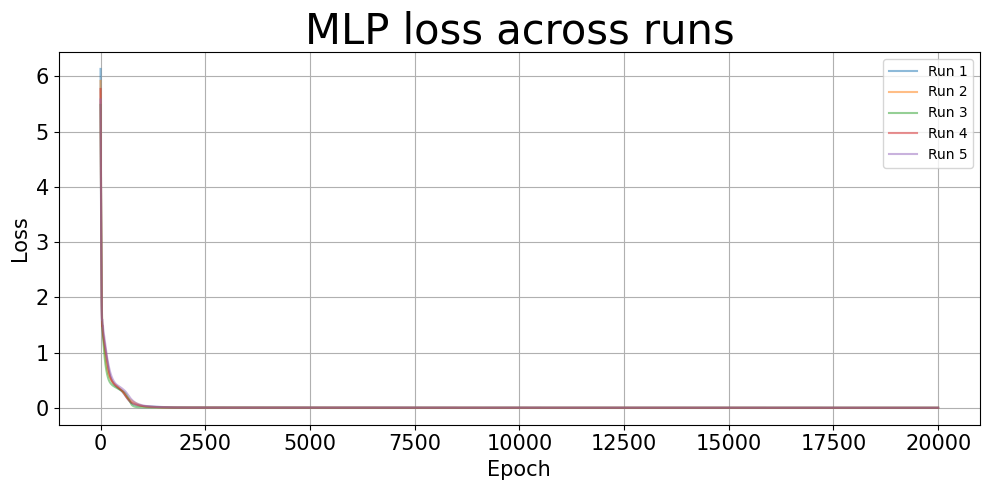

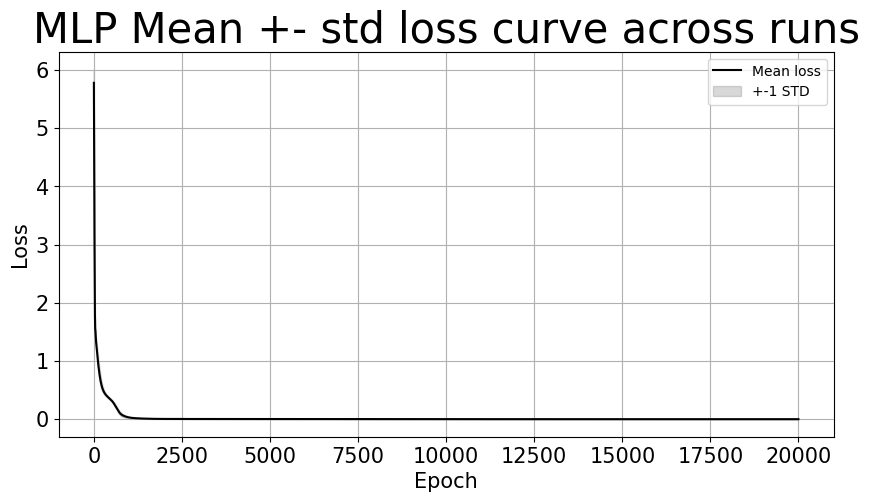

In [5]:
#loss graph
plt.figure(figsize=(10, 5))
for i, runLoss in enumerate(mlpAllLosses):
    plt.plot(runLoss, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP loss across runs", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

mlpLossArray = np.array(mlpAllLosses)
mlpMeanLoss = np.mean(mlpLossArray, axis=0)
mlpStdLoss = np.std(mlpLossArray, axis=0)

#mean and standard deviation of losses over all runs
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanLoss, label="Mean loss", color='black')
plt.fill_between(range(20000), mlpMeanLoss - mlpStdLoss, mlpMeanLoss + mlpStdLoss,
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP Mean +- std loss curve across runs", fontsize=30)
plt.grid(True)
plt.legend()
plt.show()

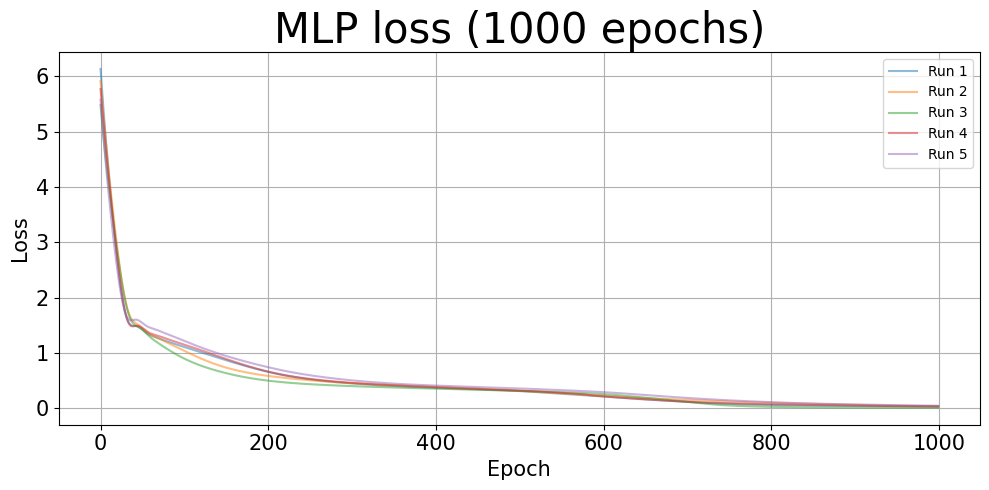

In [6]:
#loss graph restricted to 1000 epochs
plt.figure(figsize=(10, 5))
for i, runLoss in enumerate(mlpAllLosses):
    plt.plot(runLoss[:1000], label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP loss (1000 epochs)", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

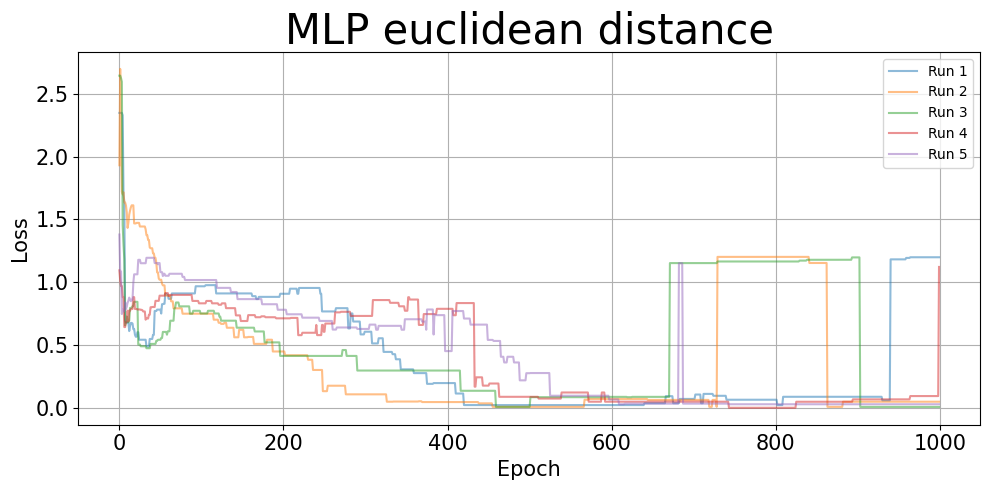

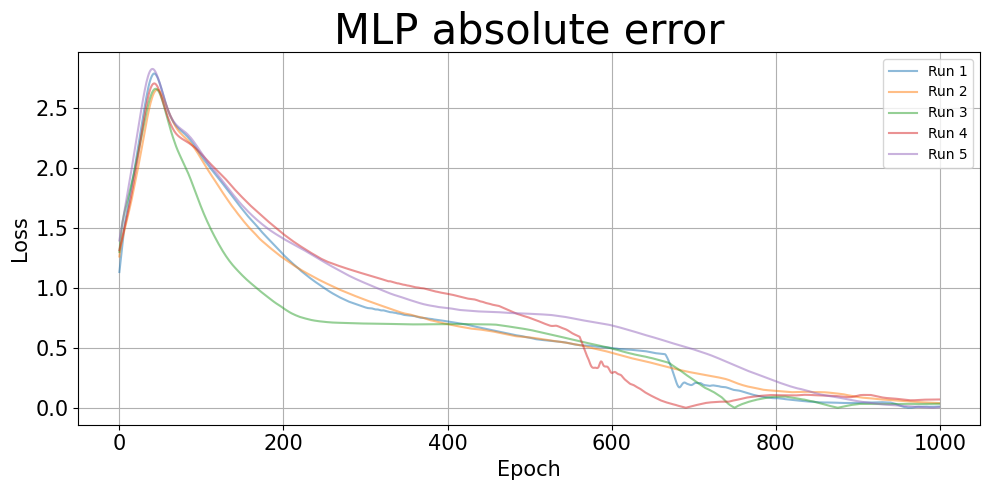

In [7]:
#euclidean distance over all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(mlpAllEuclideanAccuracies):
    plt.plot(runAccuracy[:1000], label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP euclidean distance", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#absolute error over all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(mlpAllObjectiveAccuracies):
    plt.plot(runAccuracy[:1000], label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP absolute error", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


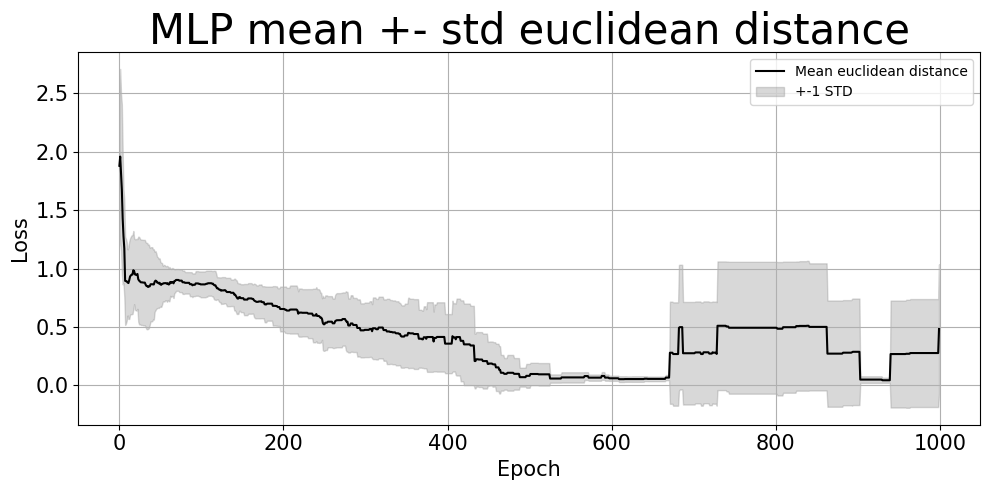

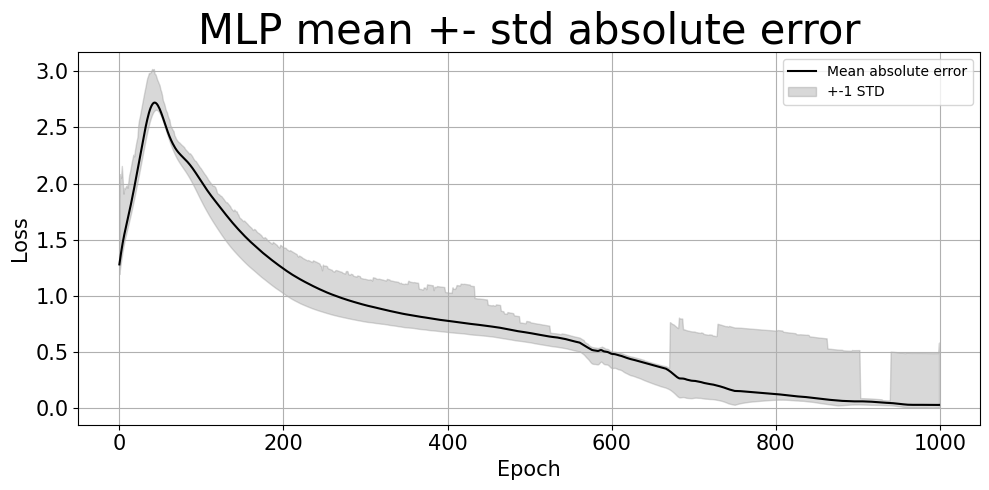

In [8]:
mlpEuclideanAccuracyArray = np.array(mlpAllEuclideanAccuracies)
mlpMeanEuclideanAccuracy = np.mean(mlpEuclideanAccuracyArray, axis=0)
mlpStdEuclideanAccuracy = np.std(mlpEuclideanAccuracyArray, axis=0)

#mean and std of euclidean distance
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanEuclideanAccuracy[:1000], label="Mean euclidean distance", color='black')
plt.fill_between(range(1000), mlpMeanEuclideanAccuracy[:1000] - mlpStdEuclideanAccuracy[:1000], mlpMeanEuclideanAccuracy[:1000] + mlpStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP mean +- std euclidean distance", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

mlpObjectiveAccuracyArray = np.array(mlpAllObjectiveAccuracies)
mlpMeanObjectiveAccuracy = np.mean(mlpObjectiveAccuracyArray, axis=0)
mlpStdObjectiveAccuracy = np.std(mlpObjectiveAccuracyArray, axis=0)

#mean and std of absolute error
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanObjectiveAccuracy[:1000], label="Mean absolute error", color='black')
plt.fill_between(range(1000), mlpMeanObjectiveAccuracy[:1000] - mlpStdObjectiveAccuracy[:1000], mlpMeanObjectiveAccuracy[:1000] + mlpStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP mean +- std absolute error", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [37]:
kanNRuns = 5
kanEpochs = 1000
kanAllLosses = []
kanSummary = []
kanAllEuclideanAccuracies = []
kanAllObjectiveAccuracies = []
kanAllCoordinates = []

for i in range(kanNRuns):
    torch.manual_seed(i)
    np.random.seed(i)
    xTrain, yTrain = generateFeasibleSamples(5000)
    yTrain = yTrain.unsqueeze(1)

    kanModel = KAN(width=[2, 4, 4, 1], grid=10, k=3, seed=np.random.randint(0,99))
    optimiser = optim.Adam(kanModel.parameters(), lr=0.01)
    runLosses = []
    kanRunEuclideanAccuracies = []
    kanRunObjectiveAccuracies = []
    kanRunCoordinates = []
    startTime = time.time()

    for epoch in range(kanEpochs):
        if epoch == 500:
            kanModel.refine(20)
        kanModel.train()
        optimiser.zero_grad()
        predictions = kanModel(xTrain)
        loss = torch.mean((predictions - yTrain) ** 2)
        loss.backward()
        optimiser.step()
        runLosses.append(loss.item())

        with torch.no_grad():
            predictions = kanModel(xTrain).squeeze()
            bestPrediction = torch.argmin(predictions)
            kanBestX = xTrain[bestPrediction]
            kanRunCoordinates.append(kanBestX)
            bestVal = predictions[bestPrediction].item()
            kanBestX1 = kanBestX[0].item()
            kanBestX2 = kanBestX[1].item()
            euclideanDistance = torch.norm(torch.tensor([kanBestX1, kanBestX2]) - torch.tensor([xAnalytical[0], xAnalytical[1]])).item()
            kanRunEuclideanAccuracies.append(euclideanDistance)
            absoluteObjectiveDifference = abs(bestVal - objAnalytical)
            kanRunObjectiveAccuracies.append(absoluteObjectiveDifference)

    endTime = time.time()
    kanAllCoordinates.append(kanRunCoordinates)
    kanAllEuclideanAccuracies.append(kanRunEuclideanAccuracies)
    kanAllObjectiveAccuracies.append(kanRunObjectiveAccuracies)
    kanAllLosses.append(runLosses)
    kanSummary.append({
        "objective": bestVal,
        "finalLoss": runLosses[-1],
        "time": endTime - startTime,
        "x1": kanBestX1,
        "x2": kanBestX2
    })
    print(f"Run {i+1}: Best x1 = {kanBestX1:.4f}, x2 = {kanBestX2:.4f} => Objective = {bestVal:.4f}, Loss = {runLosses[-1]:.4f}")

kanObjectives = [r["objective"] for r in kanSummary]
kanLosses = [r["finalLoss"] for r in kanSummary]
kanTimes = [r["time"] for r in kanSummary]
kanX1Vals = [r["x1"] for r in kanSummary]
kanX2Vals = [r["x2"] for r in kanSummary]

print(f"Mean Objective Value: {np.mean(kanObjectives):.4f} +- {np.std(kanObjectives):.4f}")
print(f"Mean Final Loss:      {np.mean(kanLosses):.4f} +- {np.std(kanLosses):.4f}")
print(f"Mean Time:            {np.mean(kanTimes):.4f}s +- {np.std(kanTimes):.4f}s")


checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
Run 1: Best x1 = -0.4422, x2 = -0.5738 => Objective = -1.4165, Loss = 0.0045
checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
Run 2: Best x1 = -0.4086, x2 = -0.5608 => Objective = -1.4014, Loss = 0.0031
checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
Run 3: Best x1 = -0.4453, x2 = -0.5849 => Objective = -1.4109, Loss = 0.0056
checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
Run 4: Best x1 = -0.4665, x2 = -0.5528 => Objective = -1.3958, Loss = 0.0035
checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
Run 5: Best x1 = -0.3934, x2 = -0.5725 => Objective = -1.3976, Loss = 0.0052
Mean Objective Value: -1.4044 +- 0.0080
Mean Final Loss:      0.0043 +- 0.0010
Mean Time:            188.8360s +- 1.3382s


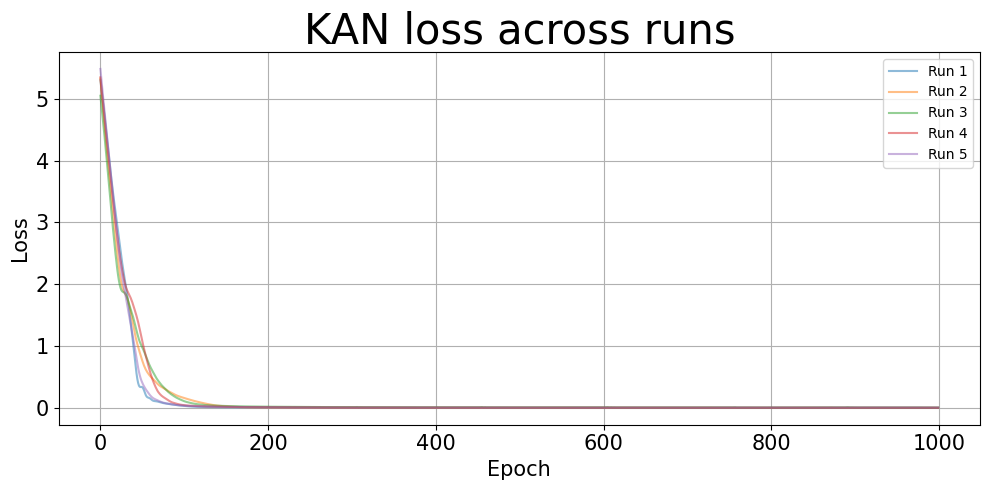

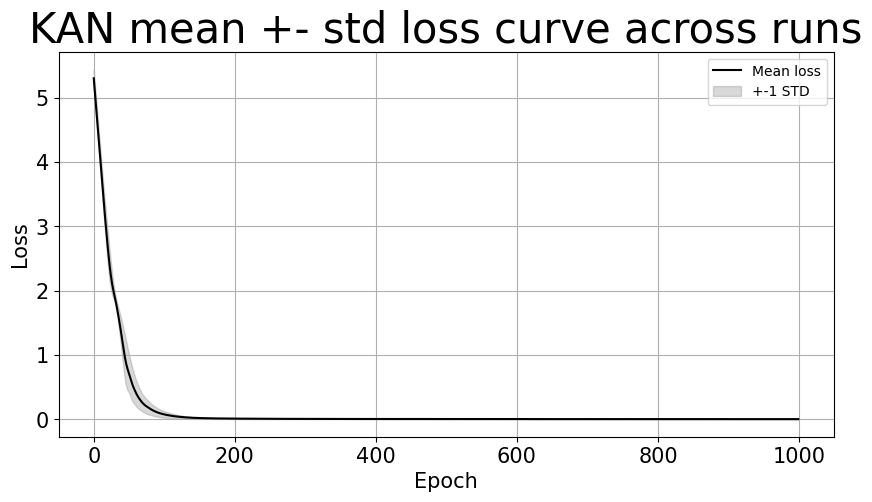

In [9]:
#loss graph
plt.figure(figsize=(10, 5))
for i, runLoss in enumerate(kanAllLosses):
    plt.plot(runLoss, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN loss across runs", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#graph of mean +- std of loss
kanLossArray = np.array(kanAllLosses)
kanMeanLoss = np.mean(kanLossArray, axis=0)
kanStdLoss = np.std(kanLossArray, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(kanMeanLoss, label="Mean loss", color='black')
plt.fill_between(range(1000), kanMeanLoss - kanStdLoss, kanMeanLoss + kanStdLoss,
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN mean +- std loss curve across runs", fontsize=30)
plt.grid(True)
plt.legend()
plt.show()



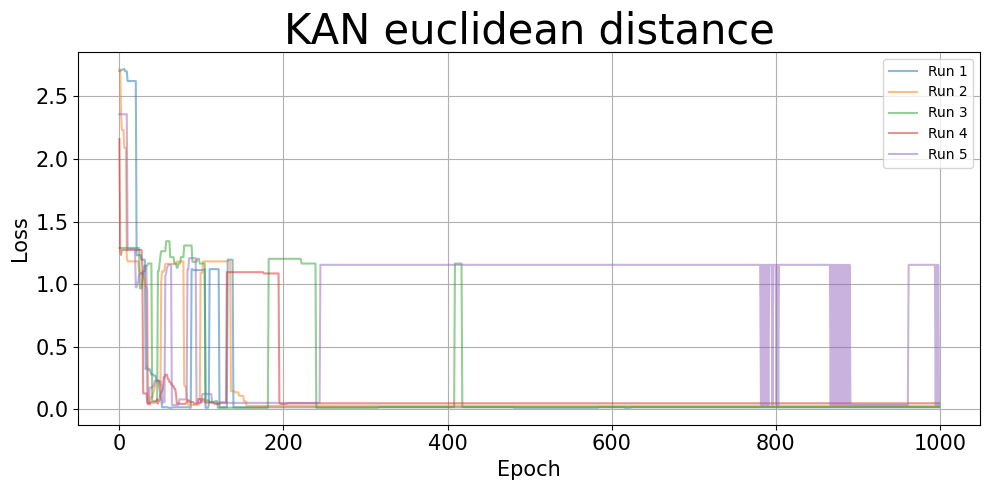

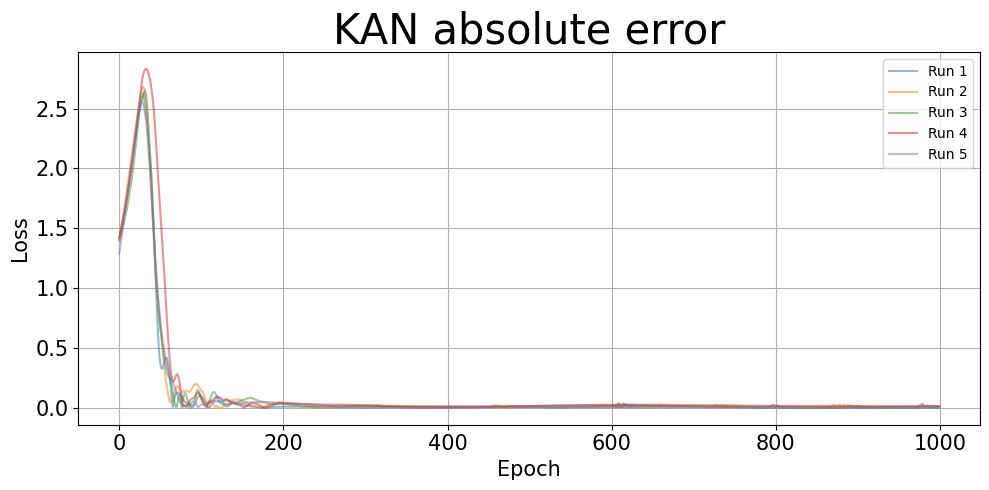

In [10]:
#kan euclidean distance across all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(kanAllEuclideanAccuracies):
    plt.plot(runAccuracy, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN euclidean distance", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#kan absolute error across all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(kanAllObjectiveAccuracies):
    plt.plot(runAccuracy, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN absolute error", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



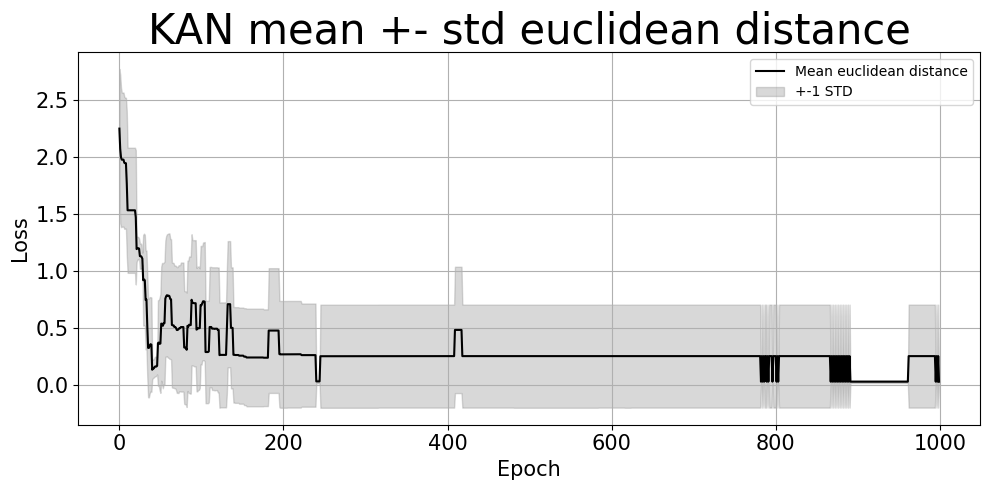

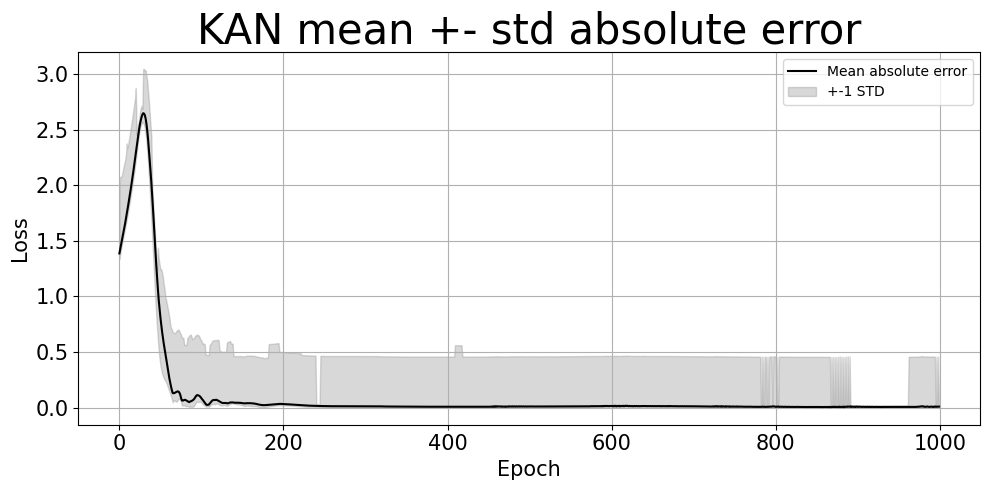

In [11]:
kanEuclideanAccuracyArray = np.array(kanAllEuclideanAccuracies)
kanMeanEuclideanAccuracy = np.mean(kanEuclideanAccuracyArray, axis=0)
kanStdEuclideanAccuracy = np.std(kanEuclideanAccuracyArray, axis=0)

#mean and std of euclidean distance
plt.figure(figsize=(10, 5))
plt.plot(kanMeanEuclideanAccuracy[:1000], label="Mean euclidean distance", color='black')
plt.fill_between(range(1000), kanMeanEuclideanAccuracy[:1000] - kanStdEuclideanAccuracy[:1000], kanMeanEuclideanAccuracy[:1000] + kanStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN mean +- std euclidean distance", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

kanObjectiveAccuracyArray = np.array(kanAllObjectiveAccuracies)
kanMeanObjectiveAccuracy = np.mean(kanObjectiveAccuracyArray, axis=0)
kanStdObjectiveAccuracy = np.std(kanObjectiveAccuracyArray, axis=0)

#mean and std of absolute error
plt.figure(figsize=(10, 5))
plt.plot(kanMeanObjectiveAccuracy[:1000], label="Mean absolute error", color='black')
plt.fill_between(range(1000), kanMeanObjectiveAccuracy[:1000] - kanStdObjectiveAccuracy[:1000], kanMeanObjectiveAccuracy[:1000] + kanStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN mean +- std absolute error", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

<b>Saving results to pickle files</b>  
If the values in the notebook are ever lost, I can just load the existing results instead of running everything again.  
with open('mlpResults.pkl', 'rb') as f:  
    mlpResults = pickle.load(f)  
with open('kanResults.pkl', 'rb') as f:  
    kanResults = pickle.load(f)  

In [41]:
import pickle

mlpResults = {
    "mlpObjectives": mlpObjectives,
    "mlpAllLosses": mlpAllLosses,
    "mlpTimes": mlpTimes,
    "mlpSummary": mlpSummary,
    "mlpAllCoordinates": mlpAllCoordinates,
    "mlpAllEuclideanAccuracies": mlpAllEuclideanAccuracies,
    "mlpAllObjectiveAccuracies": mlpAllObjectiveAccuracies
}

with open('mlpResults.pkl', 'wb') as f:
    pickle.dump(mlpResults, f)

kanResults = {
    "kanObjectives": kanObjectives,
    "kanAllLosses": kanAllLosses,
    "kanTimes": kanTimes,
    "kanSummary": kanSummary,
    "kanAllCoordinates": kanAllCoordinates,
    "kanAllEuclideanAccuracies": kanAllEuclideanAccuracies,
    "kanAllObjectiveAccuracies": kanAllObjectiveAccuracies
}

with open('kanResults.pkl', 'wb') as f:
    pickle.dump(kanResults, f)

In [42]:
#getting convergence speed
def computeConvergenceSpeed(allLosses, thresholdRatio=0.05):
    speeds = []
    for lossCurve in allLosses:
        finalLoss = lossCurve[-1]
        threshold = finalLoss * (1 + thresholdRatio)
        for i, loss in enumerate(lossCurve):
            if loss <= threshold:
                speeds.append(i)
                break
    return speeds

mlpConvergence = computeConvergenceSpeed(mlpAllLosses)
kanConvergence = computeConvergenceSpeed(kanAllLosses)

#model complexity - this is based on the parameter count for each
mlpParamCount = sum(p.numel() for p in mlpModel.parameters())
kanParamCount = sum(p.numel() for p in kanModel.parameters())

mlpBestObjective = np.max(mlpObjectives)
kanBestObjective = np.max(kanObjectives)


In [43]:
#metric comparison table
comparisonData = {
    "Metric": [
        "Mean Objective Value",
        "Std Objective Value",
        "Best Objective Value",
        "Mean Final Loss",
        "Std Final Loss",
        "Mean Time (s)",
        "Std Time (s)",
        "Mean Convergence Epoch",
        "Std Convergence Epoch",
        "Model Parameters"
    ],
    "MLP": [
        np.mean(mlpObjectives),
        np.std(mlpObjectives),
        mlpBestObjective,
        np.mean(mlpLosses),
        np.std(mlpLosses),
        np.mean(mlpTimes),
        np.std(mlpTimes),
        np.mean(mlpConvergence),
        np.std(mlpConvergence),
        mlpParamCount
    ],
    "KAN": [
        np.mean(kanObjectives),
        np.std(kanObjectives),
        kanBestObjective,
        np.mean(kanLosses),
        np.std(kanLosses),
        np.mean(kanTimes),
        np.std(kanTimes),
        np.mean(kanConvergence),
        np.std(kanConvergence),
        kanParamCount
    ]
}

comparisonDf = pd.DataFrame(comparisonData)
display(comparisonDf)


,Metric,MLP,KAN
0,Mean Objective Value,-1.412978,-1.404441
1,Std Objective Value,0.012564,0.007957
2,Best Objective Value,-1.395410,-1.395774
3,Mean Final Loss,0.000641,0.004348
4,Std Final Loss,0.000506,0.000963
5,Mean Time (s),164.020366,188.836015
6,Std Time (s),32.815814,1.338182
7,Mean Convergence Epoch,16879.200000,750.600000
8,Std Convergence Epoch,3394.267308,184.781601
9,Model Parameters,4417.000000,794.000000


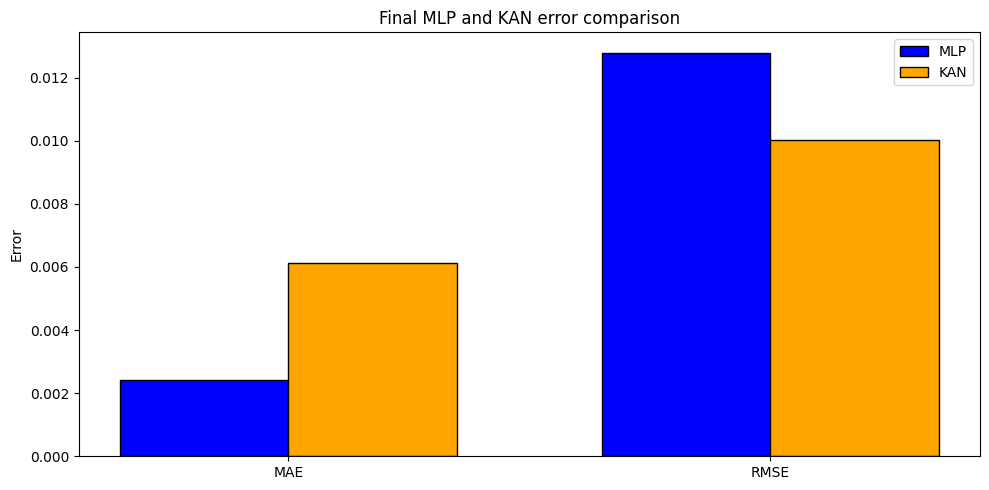

In [12]:
mlpMeanAbsError = abs(np.mean(mlpObjectives) - objAnalytical)
kanMeanAbsError = abs(np.mean(kanObjectives) - objAnalytical)
mlpRMSE = np.sqrt(np.mean((np.array(mlpObjectives) - objAnalytical)**2))
kanRMSE = np.sqrt(np.mean((np.array(kanObjectives) - objAnalytical)**2))

metrics = ['MAE', 'RMSE']
mlpErrors = [mlpMeanAbsError, mlpRMSE]
kanErrors = [kanMeanAbsError, kanRMSE]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, mlpErrors, width, label='MLP', color='blue', edgecolor='black')
plt.bar(x + width/2, kanErrors, width, label='KAN', color='orange', edgecolor='black')

plt.ylabel('Error')
plt.title('Final MLP and KAN error comparison')
plt.xticks(x, metrics)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\A\AppData\Local\Temp\ipykernel_18564\2367243651.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


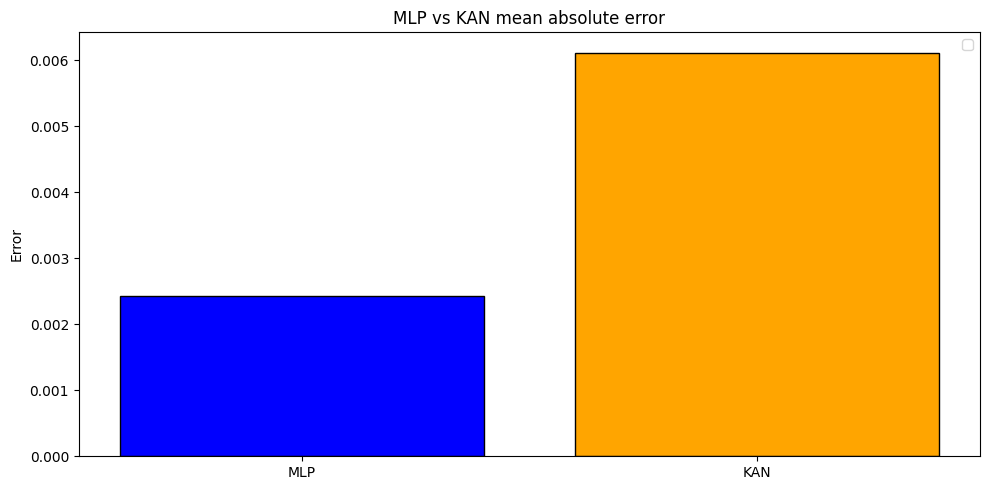

In [13]:
plt.figure(figsize=(10, 5))
plt.bar("MLP", mlpMeanAbsError, color='blue', edgecolor='black')
plt.bar("KAN", kanMeanAbsError, color='orange', edgecolor='black')
plt.ylabel('Error')
plt.title("MLP vs KAN mean absolute error")
plt.legend()
plt.tight_layout()
plt.show()


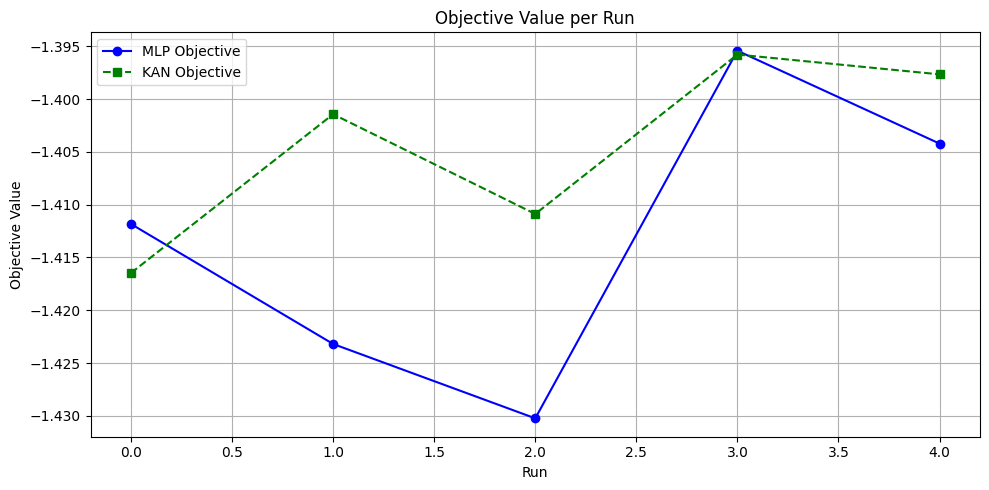

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(mlpObjectives, 'o-', label="MLP Objective", color='blue')
plt.plot(kanObjectives, 's--', label="KAN Objective", color='green')
plt.title("Objective Value per Run")
plt.xlabel("Run")
plt.ylabel("Objective Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

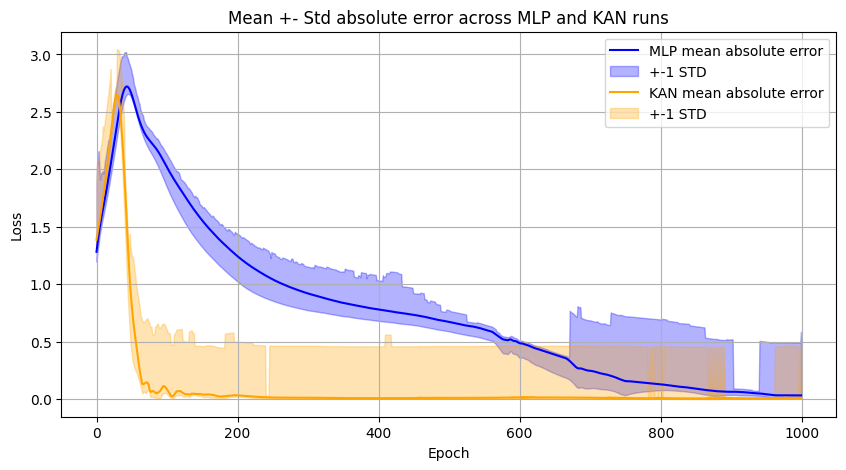

In [14]:
#absolute error comparison
start = 0
epochLimit = 1000
epochs = np.arange(start, epochLimit)
plt.figure(figsize=(10, 5))
plt.plot(epochs, mlpMeanObjectiveAccuracy[start:epochLimit], label="MLP mean absolute error", color='blue')
plt.fill_between(epochs, mlpMeanObjectiveAccuracy[start:epochLimit] - mlpStdObjectiveAccuracy[start:epochLimit], mlpMeanObjectiveAccuracy[start:epochLimit] + mlpStdEuclideanAccuracy[start:epochLimit],
                 color='blue', alpha=0.3, label="+-1 STD")
plt.plot(epochs, kanMeanObjectiveAccuracy[start:epochLimit], label="KAN mean absolute error", color='orange')
plt.fill_between(epochs, kanMeanObjectiveAccuracy[start:epochLimit] - kanStdObjectiveAccuracy[start:epochLimit], kanMeanObjectiveAccuracy[start:epochLimit] + kanStdEuclideanAccuracy[start:epochLimit],
                 color='orange', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std absolute error across MLP and KAN runs")
plt.grid(True)
plt.legend()
plt.show()

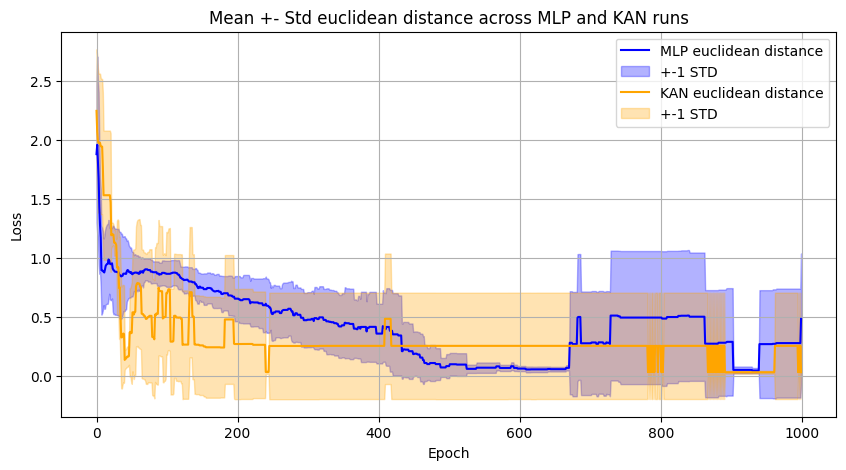

In [15]:
#euclidean distance comparison
start = 0
epochLimit = 1000
epochs = np.arange(start, epochLimit)
plt.figure(figsize=(10, 5))
plt.plot(epochs, mlpMeanEuclideanAccuracy[start:epochLimit], label="MLP euclidean distance", color='blue')
plt.fill_between(epochs, mlpMeanEuclideanAccuracy[start:epochLimit] - mlpStdEuclideanAccuracy[start:epochLimit], mlpMeanEuclideanAccuracy[start:epochLimit] + mlpStdEuclideanAccuracy[start:epochLimit],
                 color='blue', alpha=0.3, label="+-1 STD")
plt.plot(epochs, kanMeanEuclideanAccuracy[start:epochLimit], label="KAN euclidean distance", color='orange')
plt.fill_between(epochs, kanMeanEuclideanAccuracy[start:epochLimit] - kanStdEuclideanAccuracy[start:epochLimit], kanMeanEuclideanAccuracy[start:epochLimit] + kanStdEuclideanAccuracy[start:epochLimit],
                 color='orange', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std euclidean distance across MLP and KAN runs")
plt.grid(True)
plt.legend()
plt.show()

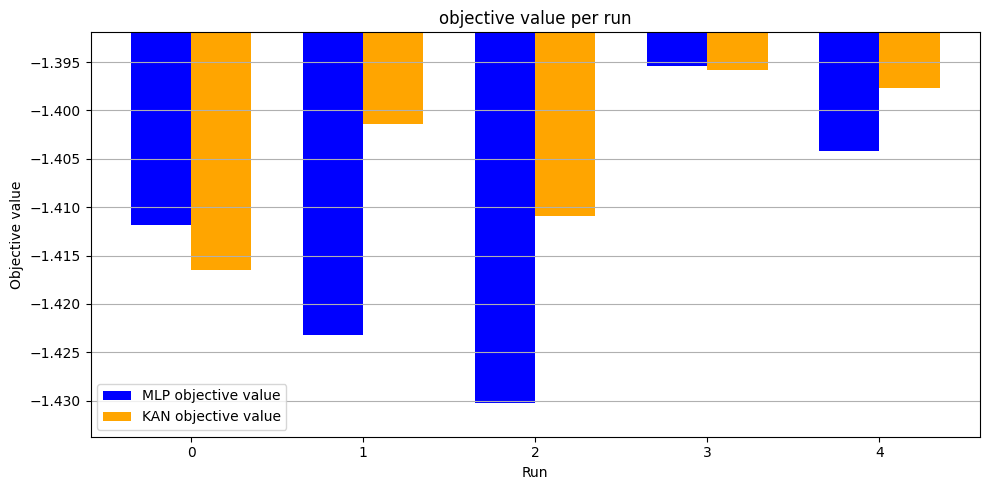

In [16]:
#bar graph of objective values in each run
runs = np.arange(len(mlpObjectives))
bar_width = 0.35
offset = bar_width / 2
plt.figure(figsize=(10, 5))
plt.bar(runs - offset, mlpObjectives, width=bar_width, label="MLP objective value", color='blue')
plt.bar(runs + offset, kanObjectives, width=bar_width, label="KAN objective value", color='orange')

plt.title("objective value per run")
plt.xlabel("Run")
plt.ylabel("Objective value")
plt.xticks(runs)
plt.legend()
plt.grid(True, axis='y')
minVal = min(min(mlpObjectives), min(kanObjectives))
maxVal = max(max(mlpObjectives), max(kanObjectives))
padding = (maxVal - minVal) * 0.1
plt.ylim(minVal - padding, maxVal + padding)
plt.tight_layout()
plt.show()

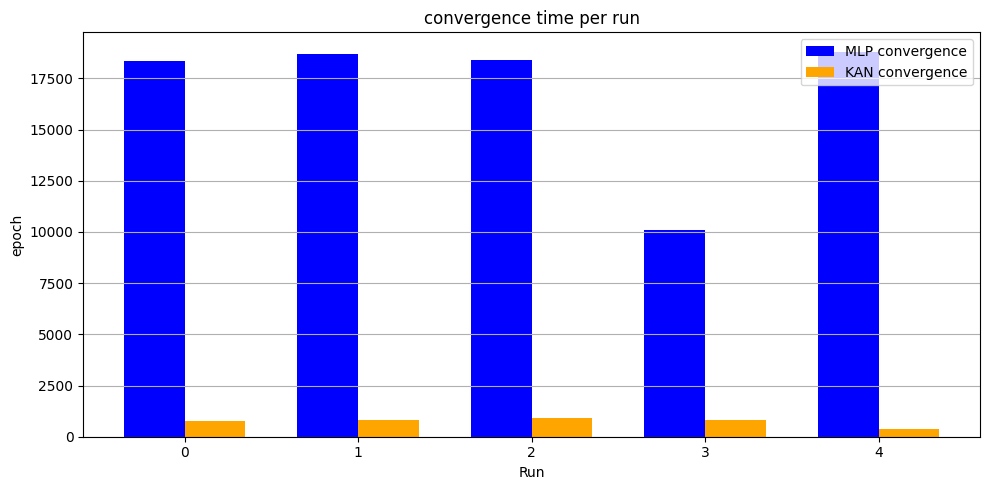

In [48]:
#convergence time comparison
runs = np.arange(len(mlpObjectives))
bar_width = 0.35
offset = bar_width / 2
plt.figure(figsize=(10, 5))
plt.bar(runs - offset, mlpConvergence, width=bar_width, label="MLP convergence", color='blue')
plt.bar(runs + offset, kanConvergence, width=bar_width, label="KAN convergence", color='orange')

plt.title("convergence time per run")
plt.xlabel("Run")
plt.ylabel("epoch")
plt.xticks(runs)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

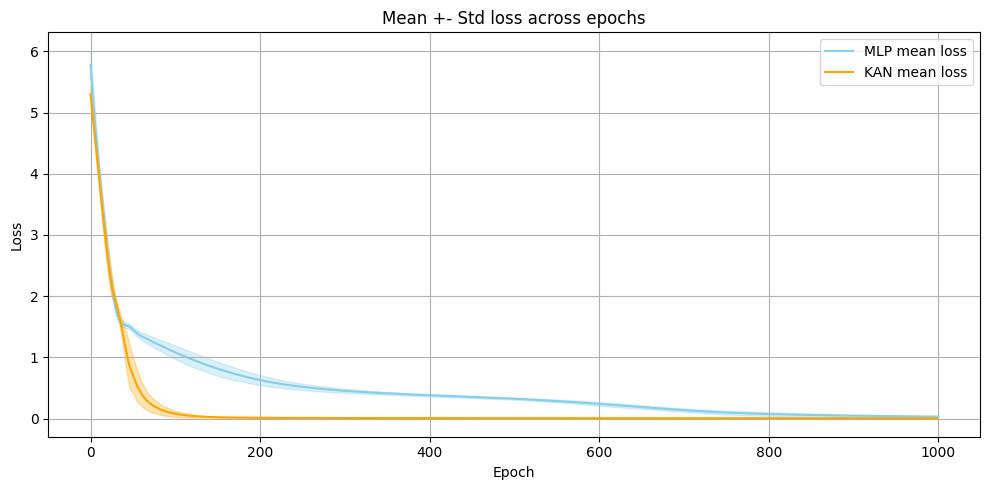

In [18]:
#loss comparison
mlpLossArray = np.array(mlpAllLosses)
kanLossArray = np.array(kanAllLosses)

mlpMeanLoss = np.mean(mlpLossArray, axis=0)[:1000]
mlpStdLoss = np.std(mlpLossArray, axis=0)[:1000]

kanMeanLoss = np.mean(kanLossArray, axis=0)
kanStdLoss = np.std(kanLossArray, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(mlpMeanLoss, label="MLP mean loss", color='skyblue')
plt.fill_between(range(len(mlpMeanLoss)),
                 mlpMeanLoss - mlpStdLoss,
                 mlpMeanLoss + mlpStdLoss,
                 alpha=0.3, color='skyblue')

plt.plot(kanMeanLoss, label="KAN mean loss", color='orange')
plt.fill_between(range(len(kanMeanLoss)),
                 kanMeanLoss - kanStdLoss,
                 kanMeanLoss + kanStdLoss,
                 alpha=0.3, color='orange')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std loss across epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


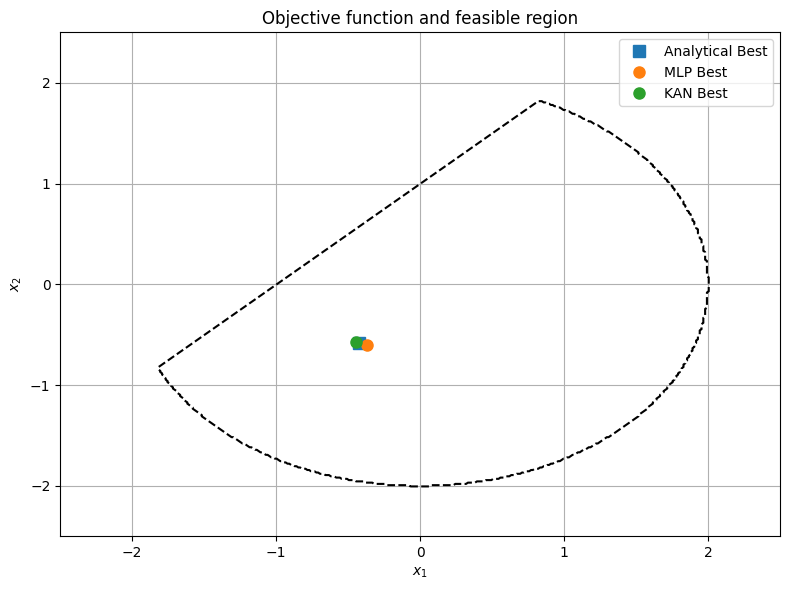

In [51]:
def f(x1, x2):
    return np.sin(3 * x1) + np.cos(5 * x2) + x1**2 + x2**2

def c1(x1, x2):
    return x1**2 + x2**2 <= 4

def c2(x1, x2):
    return x1 - x2 >= -1

x1Vals = np.linspace(-2.5, 2.5, 400)
x2Vals = np.linspace(-2.5, 2.5, 400)
X1, X2 = np.meshgrid(x1Vals, x2Vals)
Z = f(X1, X2)


feasible = c1(X1, X2) & c2(X1, X2)
plt.figure(figsize=(8, 6))
plt.contour(X1, X2, feasible, levels=[0.5], colors='black', linestyles='dashed')

plt.plot(xAnalytical[0], xAnalytical[1], 's', label='Analytical Best', markersize=8)
mlpPrediction = np.argmin(mlpObjectives)
plt.plot(mlpX1Vals[mlpPrediction], mlpX2Vals[mlpPrediction], 'o', label='MLP Best', markersize=8)
kanPrediction = np.argmin(kanObjectives)
plt.plot(kanX1Vals[kanPrediction], kanX2Vals[kanPrediction], 'o', label='KAN Best', markersize=8)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Objective function and feasible region')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
